# 📊 Introduction to COVID-19 Cases in the Philippines Dataset  

- Contains official records of confirmed COVID-19 cases in the Philippines, with demographic and temporal details.  
- Useful for analyzing pandemic trends, identifying high-risk groups, and evaluating regional and national impacts.  
- Dataset size is moderate, making it manageable for exploratory analysis, visualization, and predictive modeling.  




## 🗂 Key Attributes  

### 1. **Categorical Features**
- **Case Number** — Unique identifier for each reported case.  
- **Sex** — Gender of the patient (Male, Female, Unknown).  
- **Region / Province / City** — Geographic location of the case.  
- **Status / Outcome** — Classification such as Recovered, Died, or Active Case.  
- **Quarantine Status** — Indicates patient’s quarantine setting (home, facility, hospital).  
- **Travel History** — Record of international or domestic travel prior to confirmation (if available).  

### 2. **Numerical / Temporal Features**
- **Age** — Age of the patient at the time of diagnosis.  
- **Date Announced** — Date when the case was confirmed/reported.  
- **Date Recovered** — Date of recovery (if applicable).  
- **Date Died** — Date of death (if applicable).  
- **Month / Day** — Derived temporal features from the reporting date for time series analysis.  

### 3. **Textual / Descriptive Features**
- **Hospital Admitted** — Hospital or medical facility (if reported).  
- **Comorbidities** — Underlying health conditions of the patient.  
- **Remarks** — Other notes from the case record.

## 🛠 Preprocessing Techniques to be Used
1. **Data Cleaning**  
   - Remove duplicate records and irrelevant columns (e.g., internal codes).  
   - Standardize date formats into `YYYY-MM-DD`.  
2. **Feature Engineering**  
   - Generate binary flags (`Recovered = 1`, `Death = 1`).  
   - Group cases by region for hotspot identification.  
3. **Handling Missing Values**  
   - Fill missing ages with median values.  
   - Replace unknown sex/status with `"Unknown"`.  

# **Step 1: Connect Google Colab to your Google Drive**

![alt text](<newplot (1)-1.png>)

# **Step 2: Import the Necessary Libraries and Load the Data**

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio 

In [15]:
df = pd.read_csv(r"C:\Users\pangi\Downloads\Case_Information.csv\COVID_19_Cases_In_The_Philippines.csv")

In [16]:
df.head()

,case_id,age,age_group,sex,date_announced,date_recovered,date_of_death,status,date_announced_as_removed,province,muni_city,health_status,home_quarantined,date_of_onset_of_symptoms,pregnant,region
0,C404174,38.0,35 to 39,Female,2020-01-30,NaN,NaN,Recovered,2020-02-07,Negros Oriental,Dumaguete City,Recovered,NaN,2020-01-21,NaN,Central Visayas (Region VII)
1,C462688,44.0,40 to 44,Male,2020-02-03,NaN,2020-02-01,Died,2020-02-02,Negros Oriental,Dumaguete City,Died,NaN,2020-01-18,NaN,Central Visayas (Region VII)
2,C387710,60.0,60 to 64,Female,2020-02-05,2020-01-31,NaN,Recovered,2020-02-05,Bohol,Panglao,Recovered,No,2020-01-21,NaN,Central Visayas (Region VII)
3,C377460,48.0,45 to 49,Male,2020-03-06,NaN,NaN,Recovered,2020-03-27,Metropolitan Manila,Taguig,Recovered,No,2020-03-03,NaN,Metropolitan Manila
4,C498051,62.0,60 to 64,Male,2020-03-06,NaN,2020-03-11,Died,2020-03-12,Rizal,Cainta,Died,No,2020-02-25,NaN,CALABARZON (Region IV-A)


In [17]:
df.describe()

,age
count,12070.000000
mean,44.378708
std,18.233941
min,0.000000
25%,30.000000
50%,43.000000
75%,58.000000
max,101.000000


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12091 entries, 0 to 12090
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   case_id                    12091 non-null  object 
 1   age                        12070 non-null  float64
 2   age_group                  12070 non-null  object 
 3   sex                        12091 non-null  object 
 4   date_announced             12091 non-null  object 
 5   date_recovered             1237 non-null   object 
 6   date_of_death              657 non-null    object 
 7   status                     12091 non-null  object 
 8   date_announced_as_removed  3266 non-null   object 
 9   province                   11053 non-null  object 
 10  muni_city                  11053 non-null  object 
 11  health_status              12091 non-null  object 
 12  home_quarantined           5310 non-null   object 
 13  date_of_onset_of_symptoms  6561 non-null   obj

# **Step 3: Defining Preprocessing Steps**
 **Step 3.1: Data Cleaning**  

In [ ]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Convert date-like columns
for col in df.columns:
    if 'date' in col or 'announce' in col or 'report' in col:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Convert numeric columns
if 'age' in df.columns:
    df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Drop rows with no date information
df = df.dropna(how='all', subset=[col for col in df.columns if 'date' in col])

pio.renderers.default = 'jpeg'  # Renders as static PNG


**Step 3.2: Encoding Categorical Features**  


In [20]:
cat_features = df.select_dtypes(include=['object']).columns.tolist()
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
DATE_COL = 'date_announced' if 'date_announced' in df.columns else df.select_dtypes('datetime').columns[0]
AGE_COL = 'age' if 'age' in df.columns else '__age_num'
STATUS_COL = [c for c in df.columns if 'status' in c or 'outcome' in c][0]
REGION_COL = [c for c in df.columns if 'region' in c or 'province' in c][0]

# Derived binary flags
df['__is_recovered'] = df[STATUS_COL].astype(str).str.contains('recover', case=False, na=False).astype(int)
df['__is_death'] = df[STATUS_COL].astype(str).str.contains('dead|died|death|deceased', case=False, na=False).astype(int)



**Step 3.3: Handling of Missing Values**  

In [21]:
date_cols = [col for col in df.columns if 'date' in col]
if date_cols:
    df['month'] = df[date_cols[0]].dt.month
    df['day'] = df[date_cols[0]].dt.day
    num_features += ['month', 'day']

# **Step 4: Combining Preprocessing Steps**

In [22]:
# Numeric data pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical data pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])


# **Step 5: Applying the Preprocessing Pipeline**

In [23]:
# Apply pipeline
df_preprocessed = preprocessor.fit_transform(df)

# Retrieve encoded column names
cat_encoded_cols = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(cat_features)
all_features = np.concatenate([num_features, cat_encoded_cols])

# Convert to DataFrame
df_processed = pd.DataFrame(df_preprocessed.toarray(), columns=all_features)


print("Rows:", df_processed.shape[0], "| Columns:", df_processed.shape[1])
print(df_processed.head())

Rows: 12091 | Columns: 12568
        age     month       day  case_id_C100018  case_id_C100119  \
0 -0.350145 -4.629146  1.578517              0.0              0.0   
1 -0.020788 -3.147961 -1.261201              0.0              0.0   
2  0.857496 -3.147961 -1.050851              0.0              0.0   
3  0.198783 -1.666777 -0.945677              0.0              0.0   
4  0.967281 -1.666777 -0.945677              0.0              0.0   

   case_id_C100264  case_id_C100648  case_id_C100660  case_id_C100776  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              0.0   

   case_id_C100829  ...  region_Cordillera Administrative Region (CAR)  \
0              0.0  ...                    

# **Step 6: Analyzing the Preprocessed Data**

# **1. Data Quality Report**

In [24]:
missing_summary = df_processed.isnull().sum()
print(missing_summary)


age                                       0
month                                     0
day                                       0
case_id_C100018                           0
case_id_C100119                           0
                                         ..
region_Metropolitan Manila                0
region_Northern Mindanao (Region X)       0
region_SOCCSKSARGEN (Region XII)          0
region_Western Visayas (Region VI)        0
region_Zamboanga Peninsula (Region IX)    0
Length: 12568, dtype: int64


# **2. Visualizations**

# **1. Temporal Plot (DailyTrends of Cases, Recoveries, Deaths)**

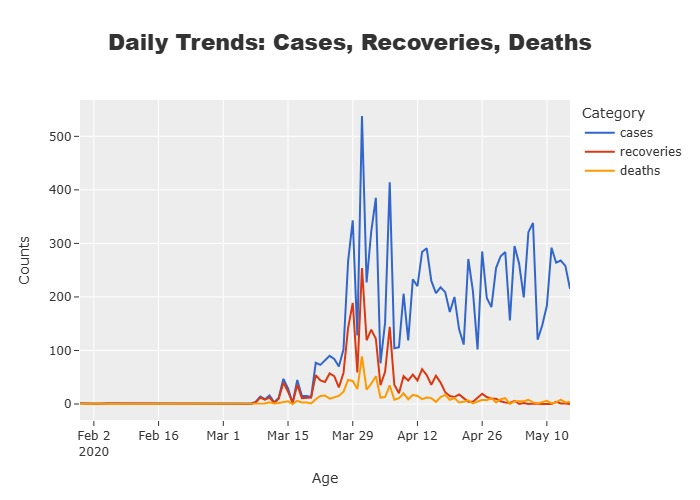

In [36]:
df_time = df.dropna(subset=[DATE_COL]).copy()
df_time['day'] = df_time[DATE_COL].dt.date
daily = df_time.groupby('day').agg(
    cases=('day', 'size'),
    recoveries=('__is_recovered', 'sum'),
    deaths=('__is_death', 'sum')
).reset_index()

fig1 = px.line(
    daily,
    x='day',
    y=['cases', 'recoveries', 'deaths'],
    title="Daily Trends: Cases, Recoveries, Deaths",
    labels={'value':'Count', 'day':'Date', 'variable':'Category'},
    color_discrete_sequence=px.colors.qualitative.G10
)

fig1.update_layout(
    title_font=dict(size=22, family='Arial Black'),
    xaxis_title='Age',
    yaxis_title='Counts',
    template='ggplot2',
    width=1920/2,
    height=1080/2
)
fig1.show()

![newplot (1).png](<attachment:newplot (1).png>)

# **2. Histogram (Age Group distribution)**

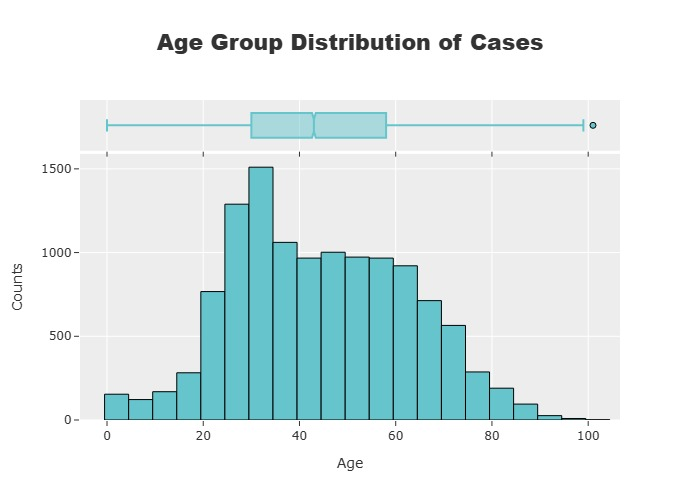

In [26]:
fig2 = px.histogram(
    df,
    x=AGE_COL,
    nbins=30,
    title="Age Group Distribution of Cases",
    marginal='box',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig2.update_layout(
    title_font=dict(size=22, family='Arial Black'),
    xaxis_title='Age',
    yaxis_title='Counts',
    template='ggplot2',
    width=1920/2,
    height=1080/2
)

fig2.update_traces(
    marker_line_width=1,
    marker_line_color='black'
)

fig2.show()

![newplot (2).png](<attachment:newplot (2).png>)

# **3. Bar Plot (Top 10 Provinces by Cases)**

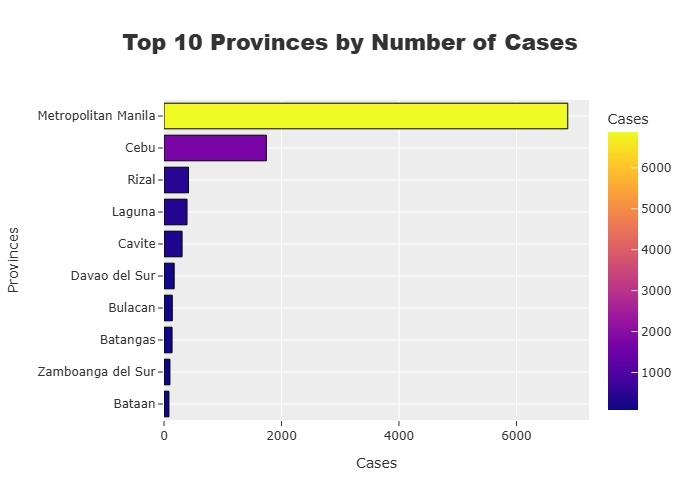

In [27]:
top_prov = df[REGION_COL].value_counts().nlargest(10).reset_index()
top_prov.columns = ['Province', 'Cases']

fig3 = px.bar(
    top_prov,
    y='Province',
    x='Cases',
    title='Top 10 Provinces by Number of Cases',
    color='Cases',
    orientation= 'h',
)

fig3.update_layout(
    title_font=dict(size=22, family='Arial Black'),
    yaxis={'categoryorder':'total ascending'},
    xaxis_title='Cases',
    yaxis_title='Provinces',
    template='ggplot2',
    width=1920/2,
    height=1080/2
)

fig3.update_traces(
    marker_line_width=1,
    marker_line_color='black'
)

fig3.show()

![newplot (3).png](<attachment:newplot (3).png>)

# **4. Scatter Plot (Age vs. Date Announced)**

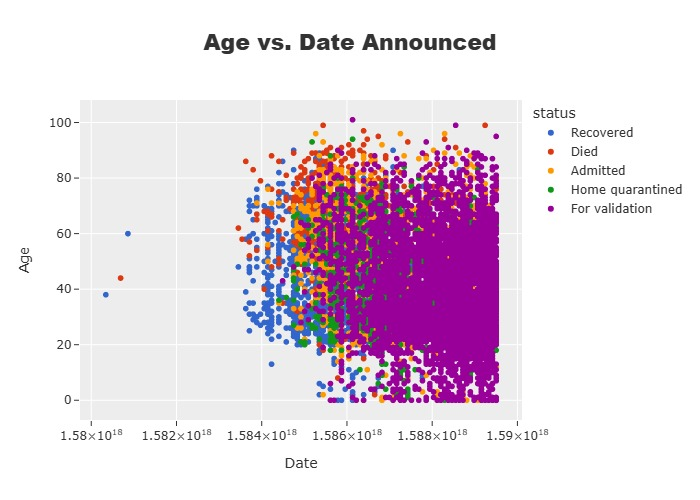

In [28]:
fig4 = px.scatter(
    df,
    x=DATE_COL,
    y=AGE_COL,
    color=STATUS_COL,
    title='Age vs. Date Announced',
    labels={'x':'Date Announced', 'y':'Age'},
    color_discrete_sequence=px.colors.qualitative.G10

)

fig4.update_layout(
    title_font=dict(size=22, family='Arial Black'),
    yaxis={'categoryorder':'total ascending'},
    xaxis_title='Date',
    yaxis_title='Age',
    template='ggplot2',
    width=1920/1.75,
    height=1080/1.75
)

fig4.show()

![newplot (4).png](<attachment:newplot (4).png>)

# **5. Box Plot (Age Distribution by Outcome)**

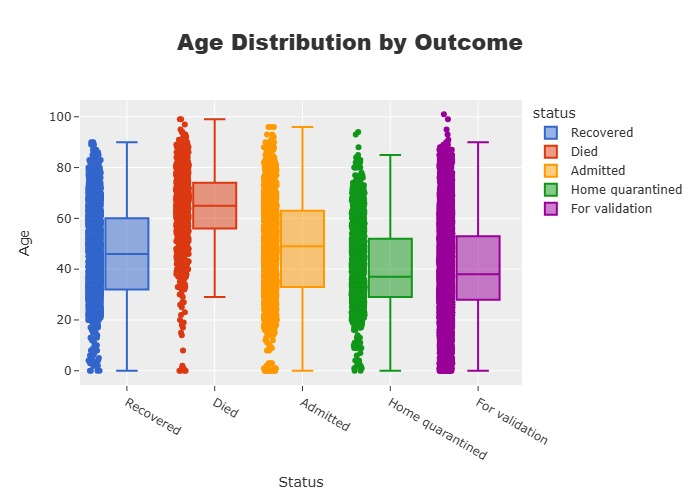

In [29]:
fig5 = px.box(
    df,
    x=STATUS_COL,
    y=AGE_COL,
    color=STATUS_COL,
    title='Age Distribution by Outcome',
    points='all',
    color_discrete_sequence=px.colors.qualitative.G10
)

fig5.update_layout(
    title_font=dict(size=22, family='Arial Black'),
    yaxis={'categoryorder':'total ascending'},
    xaxis_title='Status',
    yaxis_title='Age',
    template='ggplot2',
    width=None,
    height=1080/1.5
)


fig5.show()


![newplot (5).png](<attachment:newplot (5).png>)

# **6. KDE Plot (Case Announcements Over Time)**

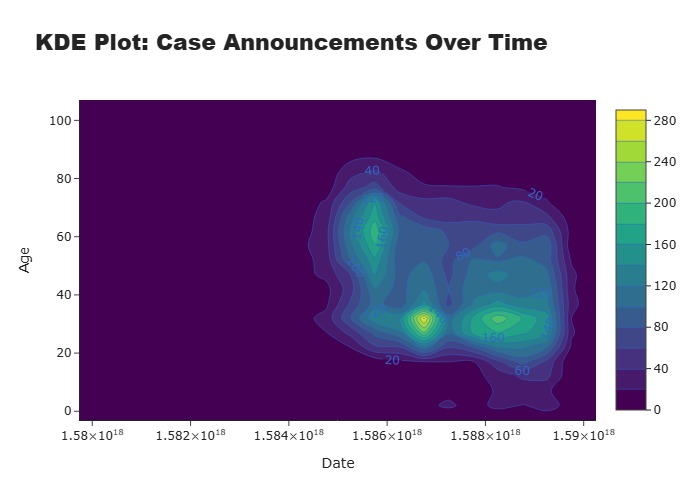

In [30]:
fig6 = px.density_contour(
    df,
    x=DATE_COL,
    y=AGE_COL,
    title="KDE Plot: Case Announcements Over Time",
    color_discrete_sequence=px.colors.qualitative.G10
)

fig6.update_layout(
    title_font=dict(size=22, family='Arial Black'),
    xaxis_title='Date',
    yaxis_title='Age',
    template= 'simple_white',
    width=1920/2,
    height=1080/2
)

fig6.update_traces(contours_coloring='fill', contours_showlabels=True)
fig6.show()

![newplot (6).png](<attachment:newplot (6).png>)

# **7. Pair Plot (Relationships Between Numeric Features)**

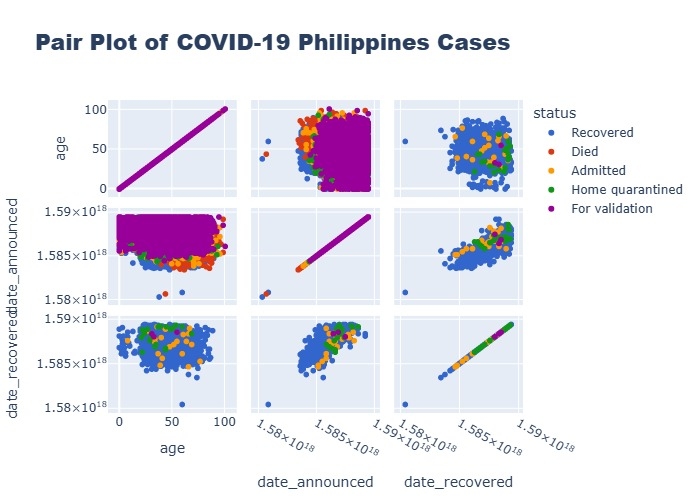

In [31]:
# Add a few more numeric-like columns if needed
if len(numeric_cols) < 2:
    possible_numeric = ['date_announced', 'date_recovered', 'date_died']
    for col in possible_numeric:
        if col in df.columns:
            numeric_cols.append(col)

if len(numeric_cols) >= 2:
    fig7 = px.scatter_matrix(
        df,
        dimensions=numeric_cols[:5],
        title='Pair Plot of COVID-19 Philippines Cases',
        color=STATUS_COL,
        color_discrete_sequence=px.colors.qualitative.G10
    )

    fig7.update_layout(
        title_font=dict(size=22, family='Arial Black'),
        dragmode='select',
        height=1536)
    fig7.update_traces(
        diagonal_visible=True)

fig7.show()

![newplot (7).png](<attachment:newplot (7).png>)

# **8. Correlation Heatmap (Age, Date Announced, Recovery/Death encoded as binary.)**

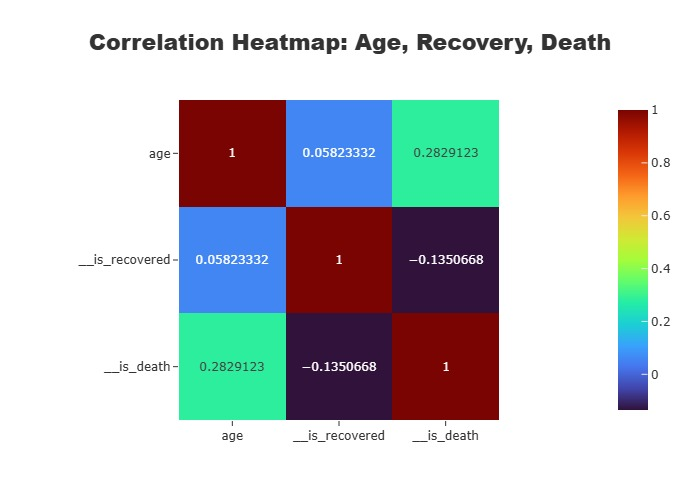

In [32]:
corr_df = df[[AGE_COL, '__is_recovered', '__is_death']].copy()
corr = corr_df.corr()
fig8 = px.imshow(
    corr,
    text_auto=True,
    color_continuous_scale='Turbo',
    title="Correlation Heatmap: Age, Recovery, Death",
)

fig8.update_layout(
    title_font=dict(size=22, family='Arial Black'),
    template= 'ggplot2',
    width=1920/2,
    height=1080/2
)
fig8.show()

![newplot (8).png](<attachment:newplot (8).png>)

# **9. Missingness Plot (Across Key Columns)**

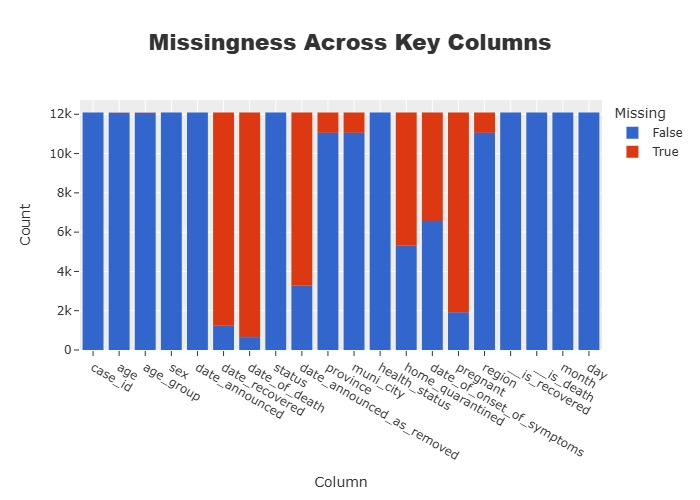

In [33]:
missing_df = df.isnull().melt(var_name='Column', value_name='Missing')
fig9 = px.histogram(
    missing_df,
    x='Column',
    color='Missing',
    title='Missingness Across Key Columns',
    color_discrete_sequence=px.colors.qualitative.G10
)

fig9.update_layout(
    title_font=dict(size=22, family='Arial Black'),
    xaxis_title='Column',
    yaxis_title='Count',
    template= 'ggplot2',
    width=1920/2,
    height=1080/1.75
)
fig9.show()

![newplot (9).png](<attachment:newplot (9).png>)

# **10. Group Heatmap (Province vs. Status)**

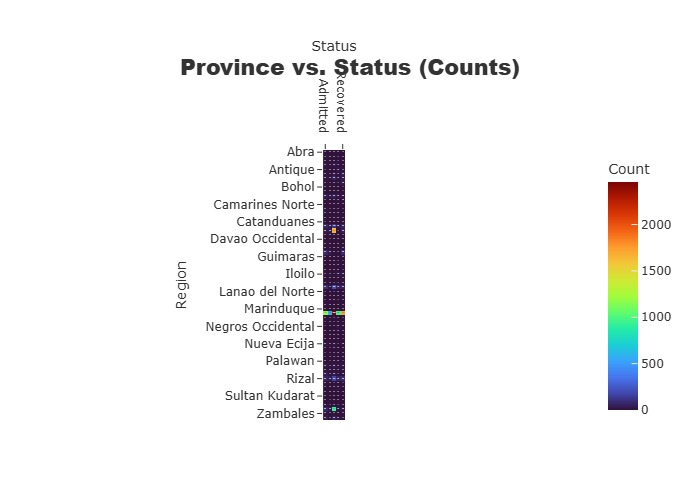

In [34]:
group_df = df.copy()
group_df['__region_grp'] = group_df[REGION_COL].fillna('Unknown').astype(str)
group_df['__status_grp'] = group_df[STATUS_COL].fillna('Unknown').astype(str)
group_counts = group_df.groupby(['__region_grp', '__status_grp']).size().reset_index(name='count')
pivot = group_counts.pivot(index='__region_grp', columns='__status_grp', values='count').fillna(0)
fig10 = px.imshow(
    pivot,
    labels=dict(x='Status', y='Region', color='Count'),
    title='Province vs. Status (Counts)',
    color_continuous_scale="turbo",
    text_auto=True,
)

fig10.update_layout(
    height=2400,
    title_font=dict(size=22, family='Arial Black'),
    template= 'ggplot2',
    title_pad=dict(b=50),  # 'b' = bottom padding (in pixels)
    margin=dict(t=150),    # top margin gives extra room above the figure
    width=1200,

    )

fig10.update_xaxes(side='top')


fig10.show()

![newplot (10).png](<attachment:newplot (10).png>)